# Importação das bibliotecas utilizadas na Analise

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from utils.B_utils import agrupar, plot_boxplot

# Conjunto de dados fornecidos pela empresa ACME

<img src="https://www.beaconjournal.com/gcdn/presto/2022/02/17/NABJ/9f2016aa-be3c-4dbb-a1cb-0de34fb5a69e-Coyote_Acme_Warner_Bros..jpg?width=660&height=330&fit=crop&format=pjpg&auto=webp">

In [2]:
( 
    axadefeito,acme,
    participacao,
    desenvolvedores
) = pd.read_excel('../ACME_dataset_1.xlsx',sheet_name=None).values()

# Pré-processamento dos dados

## Agrupando os dados de projetos que utilizaram a técnica ad-hoc e a técnica axadefeito no mesmo dataframe

In [3]:
projetos = pd.concat([acme,axadefeito]).sort_values(by='Projeto').reset_index(drop=True)
projetos.head()

,Projeto,Porte,Técnica,Tempo Inspeçao (horas),Defeitos,Esforço (h/h),Tamanho (Kloc),Produtividade (kloc/mês),SUCESSO
0,1,Pequeno,ACME,0.0,0,5.25,7,5.333333,NaN
1,2,Pequeno,ACME,0.0,0,7.50,10,5.333333,NaN
2,3,Pequeno,AXADEFEITO,0.0,0,7.50,10,5.333333,NaN
3,4,Pequeno,AXADEFEITO,0.0,0,8.00,7,3.500000,NaN
4,5,Médio,ACME,4.0,0,39.25,51,5.197452,NaN


### Preenchendo os valores nulos da coluna SUCESSO do dataframe de projetos

In [4]:
projetos.loc[
    (projetos['SUCESSO'].isna())|
    (projetos['SUCESSO'] == ' ')
    ,'SUCESSO'] = 'Y' 

### Realizando a indexação dos dados de participação pelo identificador do projeto

In [5]:
participacao = participacao.set_index('Projeto')

### Tratando os nomes de colunas que ficam os identificadores dos desenvolvedores

In [6]:
participacao.columns = participacao.columns.str.replace('Unnamed: ', '')

### Criação dos nomes de colunas que irão contabilizar a distribuições de experiência por fator de perfil de desenvolvedor

In [7]:
agg_xp_columns = ['ExperienciaRequisitos','ExperienciaProjeto','ExperienciaCodificacao']
agg_xp_columns = sorted([i+j for j in ['_L','_M','_H'] for i in agg_xp_columns])
agg_style_columns = ['Estilo1_INTUITIVO','Estilo1_RACIONAL','Estilo2_INTROVERTIDO','Estilo2_EXTROVERTIDO']

### Criação da coluna que terá uma lista com todos identificadores de desenvolvedores que estão presentes no projeto. Nesse procedimento serão excluidos identificadores de desenvolvedores duplicados

In [8]:
participacao['time'] = (
    participacao.drop(columns=['Porte']).apply(lambda x: list(x.dropna().unique()), axis=1)
)

### Criação da coluna que irá contabilizar a quantidade de identificadores de desenvolvedores para cada projeto

In [9]:
participacao['len_time'] = participacao['time'].map(lambda x: len(x))

### Criação do Dataframe que relaciona a participação com o perfil dos devs, todas as colunas relacionadas ao perfil dos desenvolvedores presentes no projeto será inicializada com 0

In [10]:
wanted_columns =  agg_xp_columns + agg_style_columns
part_x_dev = projetos[['Projeto','Porte','Técnica']].copy()
part_x_dev[wanted_columns] = 0
part_x_dev = part_x_dev.set_index('Projeto')
part_x_dev.tail()

,Porte,Técnica,ExperienciaCodificacao_H,ExperienciaCodificacao_L,ExperienciaCodificacao_M,ExperienciaProjeto_H,ExperienciaProjeto_L,ExperienciaProjeto_M,ExperienciaRequisitos_H,ExperienciaRequisitos_L,ExperienciaRequisitos_M,Estilo1_INTUITIVO,Estilo1_RACIONAL,Estilo2_INTROVERTIDO,Estilo2_EXTROVERTIDO
Projeto,,,,,,,,,,,,,,,
190,Pequeno,ACME,0,0,0,0,0,0,0,0,0,0,0,0,0
191,Grande,ACME,0,0,0,0,0,0,0,0,0,0,0,0,0
192,Grande,AXADEFEITO,0,0,0,0,0,0,0,0,0,0,0,0,0
193,Grande,ACME,0,0,0,0,0,0,0,0,0,0,0,0,0
194,Médio,ACME,0,0,0,0,0,0,0,0,0,0,0,0,0


### Avaliando quais identificadores dos desenvolvedores foram comprometidos, e contabilizando os fatores de devs por projeto

In [11]:
dev_tag_comprometidos = []
for projeto_index in range(1,195):
    for desenvolvedor_index in range(2,26):
        if not (projeto_index in participacao.index): break 
        dev_tag = participacao.loc[projeto_index,str(desenvolvedor_index)]
        if type(dev_tag) == float: break

        dev_profile_row = desenvolvedores.loc[desenvolvedores['IDENTIFICADOR']==dev_tag]
        try:
            _, xp_requisitos, xp_projetos, xp_codificacao, estilo = dev_profile_row.values.tolist()[0]
        except:
            print(f'Houve um erro referente ao dado: projeto {projeto_index} ; dev {dev_tag}')
            dev_tag_comprometidos.append((projeto_index,dev_tag))
        else:
            estilo1, estilo2 = estilo.split('/')

            part_x_dev.loc[projeto_index,'ExperienciaRequisitos_'+xp_requisitos] += 1
            part_x_dev.loc[projeto_index,'ExperienciaProjeto_'+xp_projetos] += 1
            part_x_dev.loc[projeto_index,'ExperienciaCodificacao_'+xp_codificacao] += 1
            part_x_dev.loc[projeto_index,'Estilo1_'+estilo1] += 1
            part_x_dev.loc[projeto_index,'Estilo2_'+estilo2] += 1

Houve um erro referente ao dado: projeto 2 ; dev D0018
Houve um erro referente ao dado: projeto 40 ; dev D0101
Houve um erro referente ao dado: projeto 68 ; dev D0018
Houve um erro referente ao dado: projeto 106 ; dev D0102
Houve um erro referente ao dado: projeto 157 ; dev D0102
Houve um erro referente ao dado: projeto 165 ; dev D0102
Houve um erro referente ao dado: projeto 175 ; dev D0102
Houve um erro referente ao dado: projeto 191 ; dev D0101
Houve um erro referente ao dado: projeto 193 ; dev D0101
Houve um erro referente ao dado: projeto 194 ; dev D0101


### Identificação dos projetos foram possiveis identificar algum participante

In [12]:
part_x_dev = part_x_dev.merge(participacao[['len_time']],on='Projeto',how='left')
part_x_dev['len_time'] = part_x_dev['len_time'].fillna(0.0) 

### Correção do tamanho do time em função dos identificadores comprometidos

In [13]:
for i,j in dev_tag_comprometidos:
    part_x_dev.loc[i,'len_time'] -= 1

### Distribuição de projetos em função do porte e tamanho do time 

In [14]:
part_x_dev.groupby(by=['Porte'])['len_time'].value_counts()

Porte    len_time
Grande   0.0         49
         23.0        22
         24.0         9
         22.0         8
         21.0         5
         12.0         1
         19.0         1
         20.0         1
Médio    12.0        24
         0.0         23
         11.0         2
Pequeno  4.0         25
         0.0         23
         3.0          1
Name: len_time, dtype: int64

Com base na distribuição dos projetos apresentada, observamos a ausência de projetos de grande porte com um número expressivo de membros identificáveis. Por isso, definimos como projetos de grande porte aqueles com mais de 22 integrantes identificáveis. Tal decisão introduz um risco à validade das conclusões deste estudo.

### Utilização apenas dos data points que cumprem um dos seguintes requisitos:
1. Projeto de grande porte com tamanho do time (identificavel) maior ou igual a 23 pessoas
2. Projeto de médio porte com tamanho do time (identificavel) igual a 12 pessoas
3. Projeto de pequeno porte com tamanho do time (identificavel) igual a 4 pessoas

In [15]:
part_x_dev_utilizavel = part_x_dev.loc[
    ((part_x_dev["Porte"]=="Grande") & (part_x_dev['len_time']>=23))|
    ((part_x_dev["Porte"]=="Médio") & (part_x_dev['len_time']==12))|
    ((part_x_dev["Porte"]=="Pequeno") & (part_x_dev['len_time']==4))
].copy()
part_x_dev_utilizavel.Porte.value_counts()

Grande     31
Pequeno    25
Médio      24
Name: Porte, dtype: int64

### Função para determinar o rank de cada fator de experiência e estilo de trabalho

In [16]:
for i,j in [(0,3),(3,6),(6,9)]:
    column_name = wanted_columns[i:j][0].split('_')[0]
    part_x_dev_utilizavel[column_name+'Rank'] = (part_x_dev_utilizavel[wanted_columns[i:j]] * [3,1,2]).sum(axis=1)

for i,j in [(9,11),(11,13)]:
    column_name = wanted_columns[i:j][0].split('_')[0]
    part_x_dev_utilizavel[column_name+'Rank'] = (part_x_dev_utilizavel[wanted_columns[i:j]] * [1,2]).sum(axis=1)

### Descarte das colunas de Técnica e as colunas que contabilizava a experiencia e estilo de trabalho presente em cada projeto

In [17]:
part_x_dev_utilizavel = part_x_dev_utilizavel.drop(columns=wanted_columns+['Técnica'])

### Gerando o rank percentual

In [18]:
rank_columns = {
    'ExperienciaCodificacaoRank':3,'ExperienciaProjetoRank':3,
    'ExperienciaRequisitosRank':3,'Estilo1Rank':2,'Estilo2Rank':2
}

for i in rank_columns.keys():
    part_x_dev_utilizavel[i] /= part_x_dev_utilizavel['len_time'] * rank_columns[i]

In [19]:
rank_columns = [i for i in rank_columns.keys()]

### Adicionando a coluna de SUCESSO

In [20]:
sucess_projetos = projetos.drop(columns=['Porte','Técnica','Tempo Inspeçao (horas)', 
                                'Defeitos','Esforço (h/h)', 'Tamanho (Kloc)', 
                                'Produtividade (kloc/mês)']).set_index('Projeto')

In [21]:
rank_df = part_x_dev_utilizavel.drop(columns=['len_time']).merge(sucess_projetos,on='Projeto')

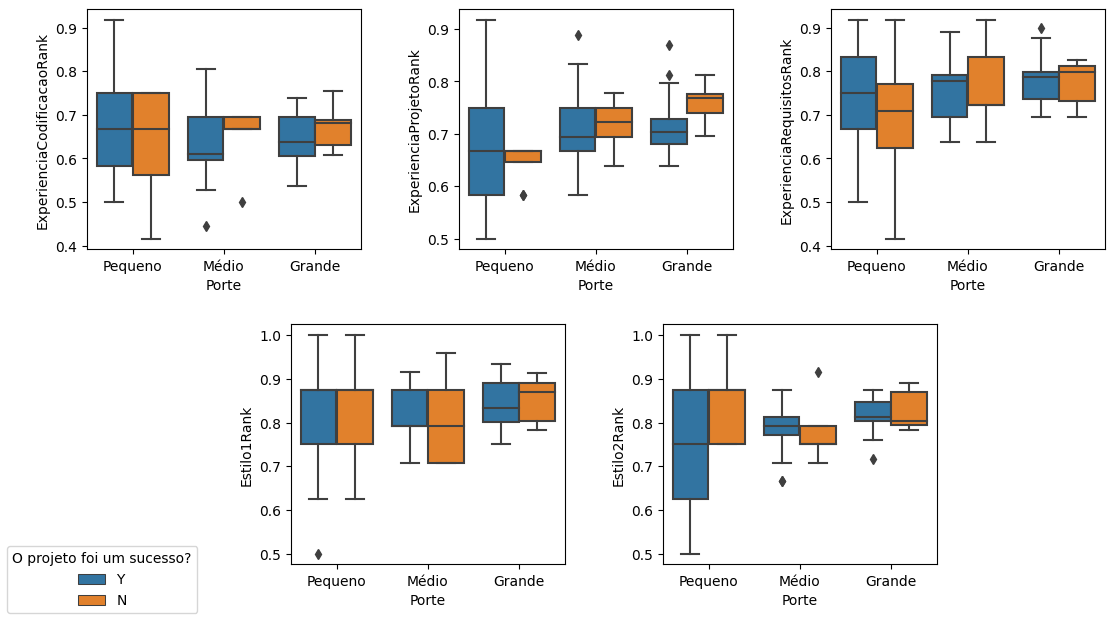

In [22]:
plot_boxplot(rank_df,rank_columns)

In [23]:
from scipy.stats import shapiro, kruskal

aux_test = []
for column in rank_columns:
    aux = rank_df.groupby(by=['Porte','SUCESSO'])[column].apply(lambda x: shapiro(x)).to_frame()
    aux_test.append(aux)

In [24]:
df_shapiro = pd.concat(aux_test,axis=1)
alfa = 0.05
for coluna in df_shapiro.columns:
    df_shapiro.loc[:,coluna+'-ShapiroResult'] = df_shapiro[coluna].map(lambda x: 'Normal' if x[1] < alfa else 'Sem evidência para rejeitar H0')
df_shapiro[[i for i in df_shapiro.columns if 'ShapiroResult' in i]]

ExperienciaCodificacaoRank-ShapiroResult  \
Porte   SUCESSO                                            
Grande  N                 Sem evidência para rejeitar H0   
        Y                 Sem evidência para rejeitar H0   
Médio   N                                         Normal   
        Y                 Sem evidência para rejeitar H0   
Pequeno N                 Sem evidência para rejeitar H0   
        Y                 Sem evidência para rejeitar H0   

                ExperienciaProjetoRank-ShapiroResult  \
Porte   SUCESSO                                        
Grande  N             Sem evidência para rejeitar H0   
        Y                                     Normal   
Médio   N             Sem evidência para rejeitar H0   
        Y                                     Normal   
Pequeno N                                     Normal   
        Y             Sem evidência para rejeitar H0   

                ExperienciaRequisitosRank-ShapiroResult  \
Porte   SUCESSO                                           
Grande  N                Sem evidência para rejeitar H0   
        Y                Sem evidência para rejeitar H0   
Médio   N                Sem evidência para rejeitar H0   
        Y                Sem evidência para rejeitar H0   
Pequeno N                Sem evidência para rejeitar H0   
        Y                Sem evidência para rejeitar H0   

                      Estilo1Rank-ShapiroResult  \
Porte   SUCESSO                                   
Grande  N        Sem evidência para rejeitar H0   
        Y        Sem evidência para rejeitar H0   
Médio   N        Sem evidência para rejeitar H0   
        Y        Sem evidência para rejeitar H0   
Pequeno N        Sem evidência para rejeitar H0   
        Y                                Normal   

                      Estilo2Rank-ShapiroResult  
Porte   SUCESSO                                  
Grande  N        Sem evidência para rejeitar H0  
        Y        Sem evidência para rejeitar H0  
Médio   N        Sem evidência para rejeitar H0  
        Y                                Normal  
Pequeno N        Sem evidência para rejeitar H0  
        Y        Sem evidência para rejeitar H0

O teste de Shapiro-Wilk formula a hipótese nula (H0) de que os dados são provenientes de uma população normalmente distribuída. Um valor de p baixo (geralmente menor que 0,05) indica que você deve rejeitar a hipótese nula, sugerindo que os dados não seguem uma distribuição normal. Por outro lado, um valor de p elevado sugere que os dados podem ser considerados como provenientes de uma distribuição normal.

Diante dos testes de shapiro-wilk, podemos observar que, em nenhum agrupamento teríamos todas as amostras com distribuição normal para realizar testes de homocedasticidade. Assim, não poderemos realizar testes de hipotése usando teste paramétricos

In [25]:
sucesso_porte_group = rank_df.groupby(by=['Porte','SUCESSO'])

results = {}
for (idx1, a), (idx2, b) in agrupar(sucesso_porte_group):
    porte = idx1[0]
    results[porte] = []
    for coluna in rank_columns:
        results[porte].append(kruskal(a[coluna], b[coluna]))

In [26]:
df_result = pd.DataFrame(results,index=rank_columns).T
df_result

,ExperienciaCodificacaoRank,ExperienciaProjetoRank,ExperienciaRequisitosRank,Estilo1Rank,Estilo2Rank
Grande,"(0.6116470025510163, 0.43416835768255535)","(5.401849217638706, 0.020115427574545947)","(0.1101075705297341, 0.7400217015281307)","(0.2033366765509725, 0.6520409505325979)","(0.0022668772668731434, 0.9620256798183219)"
Médio,"(0.2169639742307609, 0.6413630187959578)","(0.15849271510607363, 0.6905480452832351)","(0.08260188454254333, 0.7738018995124711)","(0.06563296207324884, 0.79780466337339)","(0.3973597030911405, 0.5284559759044363)"
Pequeno,"(0.0008981605671657433, 0.9760915156012935)","(0.7081948258418935, 0.40004373808385263)","(0.3195519780946202, 0.5718770141608498)","(0.06043513295730811, 0.8058095123289444)","(0.9353306540007427, 0.3334815780767019)"


In [27]:
alfa = 0.05
for column in df_result.columns:
    df_result.loc[:, column] = df_result[column].map(lambda x: 'H0 rejeitada' if x[1] < alfa else 'H0 não pode ser rejeitada')
df_result

,ExperienciaCodificacaoRank,ExperienciaProjetoRank,ExperienciaRequisitosRank,Estilo1Rank,Estilo2Rank
Grande,H0 não pode ser rejeitada,H0 rejeitada,H0 não pode ser rejeitada,H0 não pode ser rejeitada,H0 não pode ser rejeitada
Médio,H0 não pode ser rejeitada,H0 não pode ser rejeitada,H0 não pode ser rejeitada,H0 não pode ser rejeitada,H0 não pode ser rejeitada
Pequeno,H0 não pode ser rejeitada,H0 não pode ser rejeitada,H0 não pode ser rejeitada,H0 não pode ser rejeitada,H0 não pode ser rejeitada


Ao avaliar cada coluna de rank associada ao perfil da equipe responsável pelo projeto e categorizando-os por porte e resultado (sucesso ou insucesso), pudemos testar a hipótese de que existe uma diferença estatística entre amostras do mesmo porte, mas com resultados distintos. Utilizando o teste de Kruskal-Wallis, constatamos a possibilidade de rejeitar a Hipótese Nula para projetos de grande porte em relação ao fator experiência em projetos. Portanto, há indícios de que a experiência em projetos influencia a taxa de sucesso em projetos de grande magnitude.

<img src="https://static.wikia.nocookie.net/looneytunes/images/2/22/WileThatsAllFolks.png/revision/latest?cb=20180510012629">